In [1]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
Tesla T4


In [114]:
%load_ext autoreload
%autoreload 2

import sys
import os
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/coin-wear-estimator/notebook')
  !pip3 install -r ../requirements.txt --quiet
  !apt install -qq ocl-icd-* opencl-headers 

if ".." not in sys.path:
  sys.path.append("..")

import torch
if torch.cuda.is_available():
  from h2o4gpu.solvers import KMeans
else:
  from sklearn.cluster import KMeans
  
import pandas as pd
import numpy as np
import cv2
from cv2.xfeatures2d import SIFT_create as SIFTDetector
from matplotlib import pyplot as plt
from bunch import Bunch
from silx.opencl import sift as silx_sift

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms
import time
import copy
from collections import Counter
import typing

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch

from silx.opencl import sift as silx_sift

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse

from src.bow.visual_utils import *
from src.bow.bow import *
from src.utils import *
from src.grade_processing_utils import calculate_sheldon_and_categories
from src.dataset_utils import load_dataset, to_h5, join_datasets, get_h5_name
from src.master_coin_utils import convert_to_wear_marks_dataset
from src.bow.svc import optimize_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ocl-icd-dev is already the newest version (2.2.11-1ubuntu1).
ocl-icd-libopencl1 is already the newest version (2.2.11-1ubuntu1).
ocl-icd-opencl-dev is already the newest version (2.2.11-1ubuntu1).
opencl-headers is already the newest version (2.2~2018.02.21-gb5c3680-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


# Load Dataset

In [ ]:
%time

separate_sides = True
uncertain = True

dataset = join_datasets([
  load_dataset(MARCINIAK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700), uncertain=uncertain),
  load_dataset(NIEMCZYK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700), uncertain=uncertain),
])
  
to_h5(dataset, get_h5_name(separate_sides=separate_sides, uncertain=uncertain))
# dataset = load_dataset(h5_path=get_h5_name(separate_sides=separate_sides, uncertain=uncertain))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


## Two sides dataset

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))

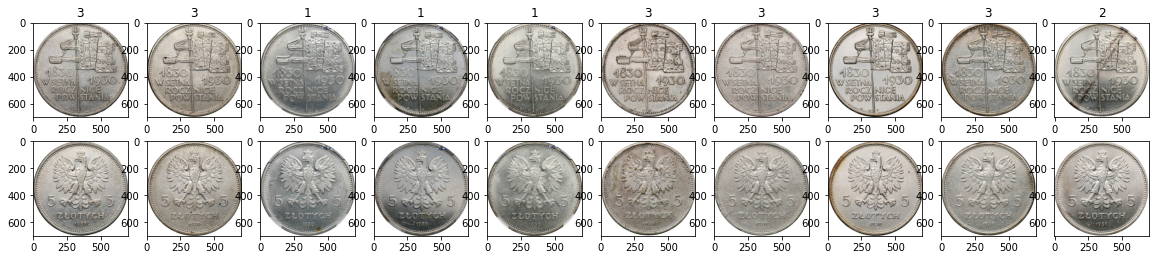

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(20,4))
ax = ax.T.flatten()
for i in range(10):
    ax[i*2].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i*2+1].imshow(cv2.cvtColor(dataset.X[i][1], cv2.COLOR_BGR2RGB))
    ax[i*2].set_title(dataset.y[i])
plt.show()

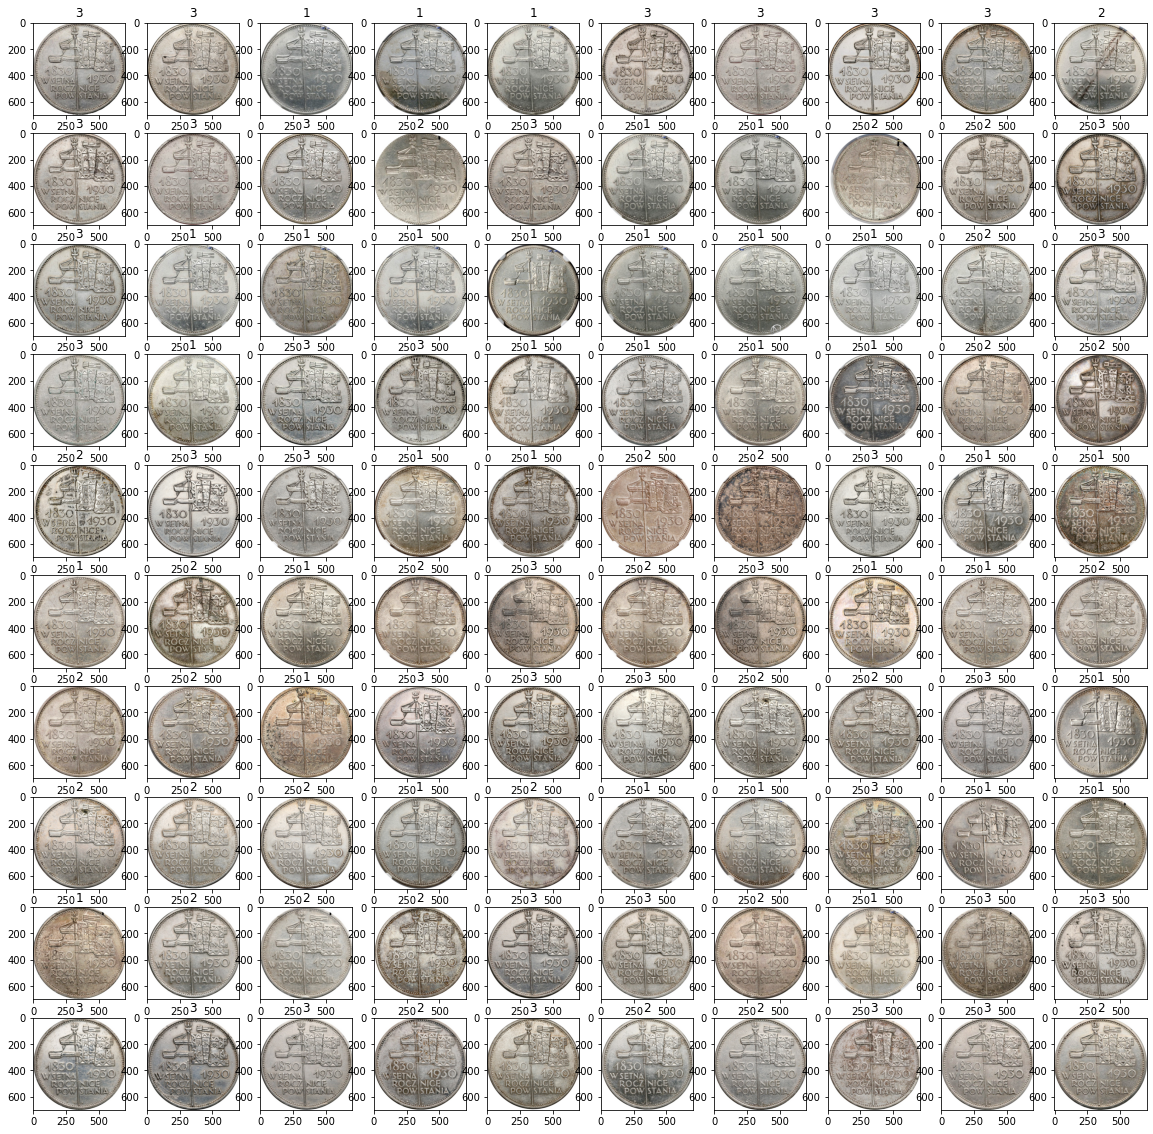

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

In [ ]:
wear_marks_dataset = convert_to_wear_marks_dataset(dataset, separate_sides=separate_sides, canny_l=None)

In [ ]:
fig, ax = plt.subplots(20, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(200):
    ax[i].imshow(cv2.cvtColor(wear_marks_dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(wear_marks_dataset.y[i])
plt.show()

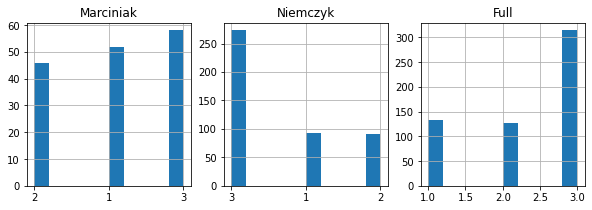

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

metadata_df = pd.read_csv(metadata_path(MARCINIAK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[0])
ax[0].set_title("Marciniak")

metadata_df = pd.read_csv(metadata_path(NIEMCZYK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[1])
ax[1].set_title("Niemczyk")

pd.Series(dataset.y).hist(ax=ax[2])
ax[2].set_title("Full")

plt.show()

## One side

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=True, uncertain=True))

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

# BoVW

In [131]:
class BriefDetector():
  def __init__(self):
    self.detector = cv2.xfeatures2d.StarDetector_create()
    self.extractor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
  
  def detectAndCompute(self, image, kp):
    kp = self.detector.detect(image, kp)
    return self.extractor.compute(image, kp)

class SiftGPUDetector():
    def __init__(self, template):
        separate_sides = template.shape[0] != 2 
        if not separate_sides:
            template=X[0]
        
        self.extractor = silx_sift.SiftPlan(template=template, devicetype="GPU")
  
    def detectAndCompute(self, image, kp):
        keypoints = self.extractor.keypoints(image, None)
        # kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in keypoints]
        des = [p.desc for p in keypoints]
        return None, des

In [132]:
AVERAGE_F1_SCORE = 'weighted'

# def getDescriptorList(X, sift_gpu=True):
#     separate_sides = X.shape[1] != 2 

#     template=X[0]
#     if not separate_sides:
#         template=X[0]
    
#     if sift_gpu:
#         sift = silx_sift.SiftPlan(template=template, devicetype="GPU")
#     else:
#         sift = cv2.xfeatures2d.SIFT_create()

#     pbar = tqdm(total=len(X))
#     descriptor_list = []
#     for i, x in enumerate(X):
#         if separate_sides:
#             des = getDescriptors(sift, x, sift_gpu)
#         else:
#             des1 = getDescriptors(sift, x[0], sift_gpu),
#             des2 = getDescriptors(sift, x[1], sift_gpu)
#             des = np.concatenate([des1, des2])

#         # if des is not None and len(des) > 0:
#         descriptor_list.append(des)
#         # else:
#         #     descriptor_list.append(np.zeros((1,128),dtype='uint8'))
          
#         pbar.update(1)
#     pbar.close()

#     return descriptor_list

def getDescriptorList(X, detector):
    separate_sides = X.shape[1] != 2 

    pbar = tqdm(total=len(X))
    descriptor_list = []
    for i, x in enumerate(X):
        if separate_sides:
            _, des = detector.detectAndCompute(x, None)
        else:
            des1 = detector.detectAndCompute(x[0], None)
            des2 = detector.detectAndCompute(x[1], None)
            des = np.concatenate([des1, des2])

        descriptor_list.append(des)          
        pbar.update(1)
    pbar.close()

    return descriptor_list



def trainModel(X_train, y_train, no_clusters, optimize_model,\
               detector, precomputed_descriptor_list=False,\
               separate_embedding=False, verbose=True):
    global train_descriptor_list

    kmeans_list = []
    scaler_list = []
    im_features_list = []

    subXs = [X_train[:,0], X_train[:,1]] if separate_embedding else [X_train]

    for i, subX in enumerate(subXs):
        if not precomputed_descriptor_list or 'train_descriptor_list' not in globals():
            if i == 0:
                train_descriptor_list = []
            train_descriptor_list.append(getDescriptorList(subX, detector))

        descriptors = np.vstack(train_descriptor_list[i])
        if verbose: print("Descriptors computed.")

        kmeans_list.append(clusterDescriptors(descriptors, no_clusters))
        if verbose: print("Descriptors clustered.")

        im_features_list.append(extractFeatures(kmeans_list[i], train_descriptor_list[i], no_clusters))
        if verbose: print("Images features extracted.")

        scaler_list.append(StandardScaler().fit(im_features_list[i]))      
        im_features_list[i] = scaler_list[i].transform(im_features_list[i])
        if verbose: print("Train images normalized.")
    
    im_features = np.concatenate(im_features_list, axis=1) if separate_embedding else im_features_list[0]

    # plotHistogram(im_features, no_clusters)
    # print("Features histogram plotted.")

    model = optimize_model(im_features, y_train)

    if verbose: print("Training completed.")

    return kmeans_list, scaler_list, model, im_features

def testModel(X_test, y_test, kmeans_list, scaler_list, model, im_features, no_clusters,
              detector,
              precomputed_descriptor_list=False,
              separate_embedding=False, verbose=True):
    global test_descriptor_list

    im_features_list = []

    subXs = [X_test[:,0], X_test[:,1]] if separate_embedding else [X_test]

    for i, subX in enumerate(subXs):
        if not precomputed_descriptor_list or 'test_descriptor_list' not in globals():
            if i == 0:
                test_descriptor_list = []
            test_descriptor_list.append(getDescriptorList(subX, detector))

        im_features_list.append(extractFeatures(kmeans_list[i], test_descriptor_list[i], no_clusters))
        im_features_list[i] = scaler_list[i].transform(im_features_list[i])

    im_features = np.concatenate(im_features_list, axis=1) if separate_embedding else im_features_list[0]
        
    predictions = model.predict(im_features)
    if verbose: print("Test images classified.")

    return predictions

def execute(
        X_train, X_test, y_train, y_test,\
        optimize_model, no_clusters,
        show_most_confused=False,
        verbose=True,
        **kwargs): 

    kmeans_list, scaler_list, model, im_features = trainModel(
        X_train, y_train, no_clusters, optimize_model,
        verbose=verbose,
        **kwargs)
    
    global train_predictions,test_predictions
    train_predictions = model.predict(im_features)
    test_predictions = testModel(X_test, y_test,
                                 kmeans_list,
                                 scaler_list,
                                 model, im_features, no_clusters,
                                 verbose=verbose,
                                 **kwargs)

    train_loss = f1_score(y_train, train_predictions, average=AVERAGE_F1_SCORE)
    test_loss = f1_score(y_test, test_predictions, average=AVERAGE_F1_SCORE)

    if verbose: plotConfusions(y_test, test_predictions)    
    if verbose: print("Train %.4f F1 score: (%s)" % (train_loss, AVERAGE_F1_SCORE))
    if verbose: print("Test %.4f F1 score (%s): "% (test_loss, AVERAGE_F1_SCORE))

    return train_loss, test_loss

    # if show_most_confused:
    #   idx = train_predictions != test_predictions
    #     onehot_encoder = OneHotEncoder(sparse=False)
    #     y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
    #     mse_loss = pd.DataFrame("", index=np.arange())
    #     print(model.predict_proba(test_features))
    # print(onehot_encoded - y_test)   

def experiment(
    X_train, X_test, y_train, y_test, estimator, param_constructor, 
    n_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    **kwargs):

    for n in n_list:
        optimizer = lambda x, y : optimize_model(x, y, estimator, param_constructor(n))
        train_loss, test_loss = execute(X_train, X_test, y_train, y_test, optimizer, n, verbose=len(n_list)==1, **kwargs)
        print(n, train_loss, test_loss)

## Experiments

Train-test : 0.7-0.3 \
Wear state categories: 

Wear marks extraction:
* Resize (700 x 700)

Models:
* SVC
* KNN
* RF
* LR

SIFT Keypoints

**Experiment set 1**

Wear levels:
* UNC
* Pre-UNC
* CIRC

1.1 Each side is considered separetaly.\
1.2 Each coin considered as list descriptors of both obverse and reverse.\
1.3 Each coin considered as concatenation of embeddings for obverse and reverse.

**Experiment set 2**

Wear levels:
* 1
* 1.5
* 2
* 2.5
* 3

### 1.1

In [137]:
# dataset = load_dataset(h5_path=get_h5_name(separate_sides=True, uncertain=False))
# wear_marks_dataset = dataset
flags = {
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector(wear_marks_dataset.X[0])# BriefDetector, SIFTDetector
    # 'detector': BriefDetector()
}

### 1.2

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))
wear_marks_dataset = dataset
flags = {
    'sift_gpu': True,
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
}

### 1.3

In [7]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))
wear_marks_dataset = dataset
flags = {
    'sift_gpu': True,
    'precomputed_descriptor_list': True,
    'separate_embedding': True, 
}

### 2.1

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=True, uncertain=True))
wear_marks_dataset = dataset
flags = {
    'sift_gpu': True,
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
}

In [ ]:
# from src.parser.MarciniakParser import MarciniakParser
# from src.parser.NiemczykParser import NiemczykParser
# from src.grade_processing_utils import unify_states, get_circulate_category

# keyword = "Sztandar 1930"
# df = pd.concat([
#            unify_states(NiemczykParser().get_df_with_states(keyword)),
#            unify_states(MarciniakParser().get_df_with_states(keyword)),
# ],ignore_index=True)

# df[df["state"] == "2+/1-"]
# arr = df['state'].values
# ind = [s.startswith("GCN") or s.startswith("NGC") or s.startswith("PCGS") for s in arr]
# exp = [get_shaldon_value(s) for s in df.loc[ind, 'state']]
# exp = [get_circulate_category(s) for s in exp]

# wear_marks_dataset.X = wear_marks_dataset.X[ind]
# wear_marks_dataset.y = wear_marks_dataset.y[ind]
# wear_marks_dataset.name = wear_marks_dataset.name[ind]
# wear_marks_dataset.side = wear_marks_dataset.side[ind]

## Models

In [121]:
[X_train, X_test, y_train, y_test, name_train, name_test] = train_test_split(
    wear_marks_dataset.X,
    wear_marks_dataset.y,
    wear_marks_dataset.name,
    stratify=wear_marks_dataset.y,
    test_size=0.3,
    random_state=42)

### SVM

In [154]:
%time

param_constructor = lambda n: {
    'class_weight': ['balanced'],
    'C': [
        #   10,
        #   5,
        #   1.3, 
        #   1.1,
          1,
        #   0.9,
          0.7, 
          1/5,
          1/10
          ],
    'kernel': [
            #    'linear',
            #    'poly', 
               'rbf',
            #    'sigmoid'
               ],
    'gamma': [
            #   10/n,
              5/n, 
              2/n, 
              1/n,
              1/(2*n), 
              1/(5*n), 
            #   1/(10*n)
             ]
    }

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'C': 0.7, 'class_weight': 'balanced', 'gamma': 0.29411764705882354, 'kernel': 'rbf'}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.58 0.26 0.16]
 [0.32 0.32 0.35]
 [0.16 0.24 0.6 ]]


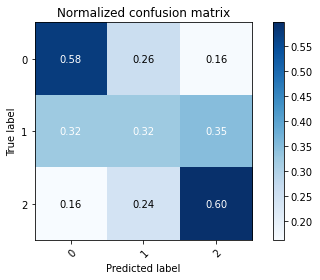

Train 0.7749 F1 score: (weighted)
Test 0.5449 F1 score (weighted): 
17 0.7749267317065489 0.5449020843144133


In [155]:
n = 17
experiment(X_train, X_test, y_train, y_test, SVC, param_constructor, n_list=[n], **flags)

In [144]:
experiment(X_train, X_test, y_train, y_test, SVC, param_constructor, n_list = [5, 9, 13, 17, 21], **flags)

{'C': 10, 'class_weight': 'balanced', 'gamma': 0.04, 'kernel': 'rbf'}
5 0.5588030623944502 0.5067511985181957
{'C': 5, 'class_weight': 'balanced', 'gamma': 0.5555555555555556, 'kernel': 'rbf'}
9 0.843223186111368 0.5070709798858124
{'C': 5, 'class_weight': 'balanced', 'gamma': 0.15384615384615385, 'kernel': 'rbf'}
13 0.7718383356808016 0.5281993747484088
{'C': 0.7, 'class_weight': 'balanced', 'gamma': 0.29411764705882354, 'kernel': 'rbf'}
17 0.767466167068363 0.5566983362942334
{'C': 0.7, 'class_weight': 'balanced', 'gamma': 0.23809523809523808, 'kernel': 'rbf'}
21 0.8231175768540259 0.5213619750010546


### KNN

In [95]:
param_constructor = lambda n: {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [ ]:
experiment(X_train, X_test, y_train, y_test, KNeighborsClassifier, param_constructor, **flags)

Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.47 0.14 0.39]
 [0.23 0.21 0.56]
 [0.1  0.1  0.79]]


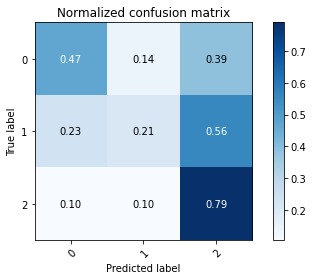

Train 1.0000 F1 score: (weighted)
Test 0.5649 F1 score (weighted): 
21 1.0 0.5649433618188321


In [96]:
n_features = 21
experiment(X_train, X_test, y_train, y_test, KNeighborsClassifier, param_constructor, n_list=[n_features], **flags)

### RF

In [102]:
%time

param_constructor = lambda n: {
    'n_estimators' : [7, 10, 15, 20, 30],
    'criterion' : ['gini', 'entropy'],
    'class_weight' : [
                      "balanced",
                      "balanced_subsample",
                      ],
    'max_depth': [2,3,4]
}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [98]:
experiment(X_train, X_test, y_train, y_test, RandomForestClassifier, param_constructor, **flags)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 7}
3 0.6862817203368937 0.45482450212461717
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 7}
5 0.7647468767548056 0.5102419330382305
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
7 0.8341127949874938 0.5481982683115828
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
9 0.8440724350563342 0.5458095420246548
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
11 0.8347975863688121 0.5510620934551357
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
13 0.8342459892572303 0.5345109864811126
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 10}
15 0.86421250484303 0.5684249364394158
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
17 0.83221362324

Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 20}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.6  0.21 0.19]
 [0.39 0.36 0.25]
 [0.21 0.21 0.58]]


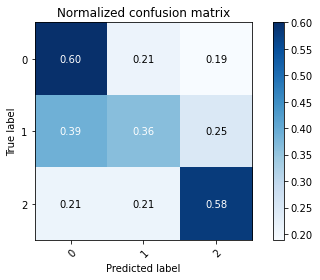

Train 0.6658 F1 score: (weighted)
Test 0.5506 F1 score (weighted): 
15 0.6658436579253233 0.5506043196255278


In [103]:
n_features = 15    
experiment(X_train, X_test, y_train, y_test, RandomForestClassifier, param_constructor, n_list=[n_features], **flags)

### LR

In [104]:
param_constructor = lambda n:  {
    'C': [0.7, 0.3, 0.1, 0.05, 0.01],
    'class_weight' : ["balanced",],
    'max_iter': [100]
}

{'C': 0.05, 'class_weight': 'balanced', 'max_iter': 100}
3 0.5128315712954764 0.5074863318292685
{'C': 0.3, 'class_weight': 'balanced', 'max_iter': 100}
5 0.552726083128834 0.5232665938629115
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100}
7 0.5570866957832915 0.5263722968446587
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100}
9 0.569736575594345 0.558376732111458
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100}
11 0.5882704562065701 0.5545573993183078
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100}
13 0.5935349895818526 0.5646470283357119
{'C': 0.7, 'class_weight': 'balanced', 'max_iter': 100}
15 0.6081770196991555 0.5742210702286581
{'C': 0.05, 'class_weight': 'balanced', 'max_iter': 100}
17 0.5986835506686052 0.564894504772598
{'C': 0.3, 'class_weight': 'balanced', 'max_iter': 100}
19 0.6100609918029675 0.5739845966082003
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100}
21 0.6025454800211546 0.5799761322582788


In [ ]:
experiment(X_train, X_test, y_train, y_test, LogisticRegression, param_constructor, **flags)

Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.55 0.31 0.14]
 [0.29 0.42 0.3 ]
 [0.2  0.17 0.63]]


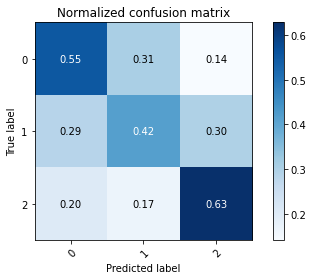

Train 0.6002 F1 score: (weighted)
Test 0.5762 F1 score (weighted): 
21 0.6001586717670282 0.5761855379587707


In [105]:
n_features = 21  
experiment(X_train, X_test, y_train, y_test, LogisticRegression, param_constructor, n_list=[n_features], **flags)

## Error analysys

In [88]:
from src.grade_processing_utils import unify_states

idx = test_predictions != y_test
metadata_dict = {
    i: unify_states(pd.read_csv(metadata_path(path), sep="|", index_col="id")[["title_state","description_state"]])
                 for i, path in (("N", NIEMCZYK_DATASET_PATH), ("M", MARCINIAK_DATASET_PATH))
} 
missclassified_df = pd.DataFrame({
    "name": name_test[idx],
    "pred": test_predictions[idx],
    "true": y_test[idx],
    "state": [metadata_dict[n[0]].loc[int(n.split("_")[0][1:]),"state"] for n in name_test[idx]]
    })

missclassified_experts = sum([s.startswith("GCN") or s.startswith("NGC") or s.startswith("PCGS") for s in missclassified_df["state"]])

print("%.2f of missclassified labels are not expert grades" % (1 - missclassified_experts/len(missclassified_df)))
print(missclassified_df)
missclassified_experts

# arr = df['state'].values
# ind = [s.startswith("GCN") or s.startswith("NGC") or s.startswith("PCGS") for s in arr]
# exp = [get_shaldon_value(s) for s in df.loc[ind, 'state']]
# exp = [get_circulate_category(s) for s in exp]

0.64 of missclassified labels are not expert grades
           name pred true      state
0    N387_1.jpg    2    3      2-/3+
1     N98_2.jpg    1    3         3+
2    N420_1.jpg    2    3       3-/4
3    N393_2.jpg    2    3         2-
4    N141_2.jpg    2    3         2-
..          ...  ...  ...        ...
147   M36_1.jpg    2    1  PCGS MS62
148  N198_2.jpg    2    3         3+
149  N127_2.jpg    2    1       1/1-
150  M114_2.jpg    1    2  PCGS AU58
151  N193_1.jpg    2    3          3

[152 rows x 4 columns]


54

## Separate classifier for each side

In [ ]:
ts_dataset = load_dataset(h5_path="two_sides_ds.h5")
ts_dataset_1 = Bunch(X=[x[0] for x in ts_dataset.X], y=ts_dataset.y)
ts_dataset_2 = Bunch(X=[x[1] for x in ts_dataset.X], y=ts_dataset.y)

In [ ]:
execute(ts_dataset_1, optimize_svm, 16, sift_gpu=True, precomputed_descriptor_list=False)

NameError: ignored

Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.
0.9 rbf 0.03125
Train weighted F1 score:  0.6785736212923476
Training completed.
Test images classified.
Confusion matrix, without normalization
[[32 10  3]
 [23 15 11]
 [16 20 42]]
Normalized confusion matrix
[[0.71 0.22 0.07]
 [0.47 0.31 0.22]
 [0.21 0.26 0.54]]


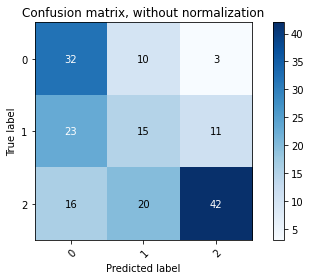

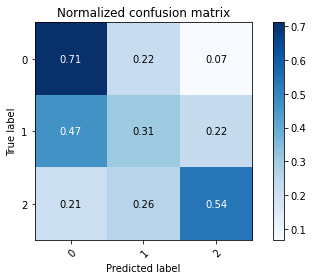

Confusion matrixes plotted.
Test weighted F1 score:  0.5195430608563761
Execution done.


In [ ]:
execute(ts_dataset_2, optimize_svm, 16, sift_gpu=True, precomputed_descriptor_list=False)

## SIFT comparison

In [ ]:
class BriefDetector():
  def __init__(self):
    self.detector = cv2.xfeatures2d.StarDetector_create()
    self.extractor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
  
  def detectAndCompute(self, image, kp):
    kp = self.detector.detect(image, kp)
    return self.extractor.compute(image, kp)

class SiftGPUDetector():
    def __init__(self, template):
        self.extractor = silx_sift.SiftPlan(template=template, devicetype="GPU")
  
    def detectAndCompute(self, image, kp):
        keypoints = self.extractor.keypoints(img, None)
        # kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in keypoints]
        des = [kp.desc for p in keypoints]
        return None, des

In [ ]:
len(des_brief[3])
kp_gpu = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in sift_gpu.keypoints(img, None)]


32

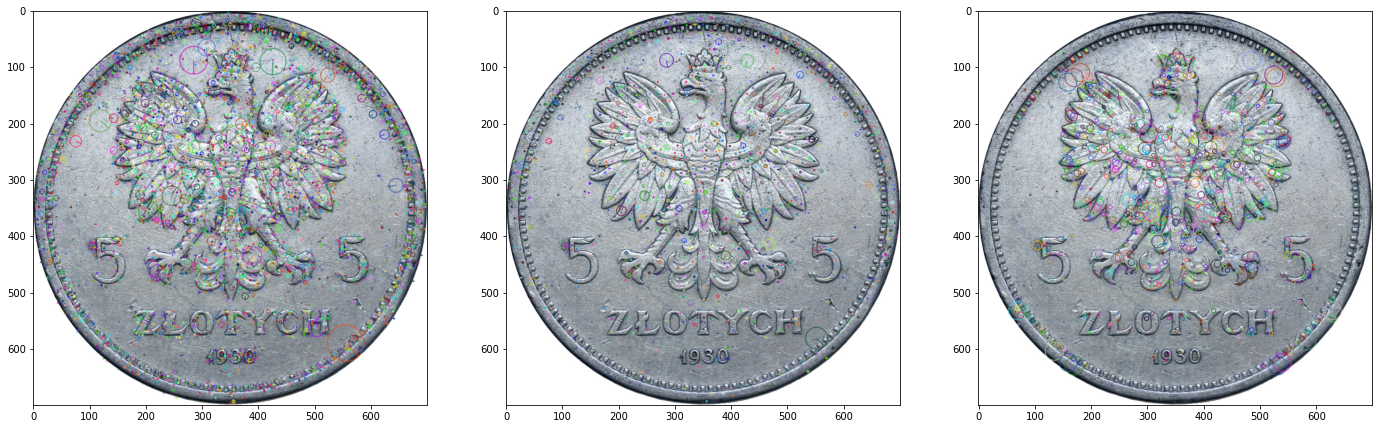

In [ ]:
img = wear_marks_dataset.X[20]
# img = cv2.resize(img, (300,300))
sift_gpu = silx_sift.SiftPlan(template=img, devicetype="GPU")
sift = cv2.xfeatures2d.SIFT_create()
brief = BriefDetector()

kp_brief, des_brief = brief.detectAndCompute(img, None)
kp, des = sift.detectAndCompute(img, None)
kp_gpu = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in sift_gpu.keypoints(img, None)]

img_1 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2 = cv2.drawKeypoints(img, kp_gpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_3 = cv2.drawKeypoints(img, kp_brief, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1, 3, figsize=(24,8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)
plt.show()

# CNN

In [ ]:
from torchvision import transforms, models
import torchvision
from PIL import Image

In [ ]:
wear_marks_dataset = dataset

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        # self.targets = torch.LongTensor(targets)
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
        return x, int(y-1)

    def __len__(self):
        return len(self.data)

In [ ]:
data_transforms = transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

[X_train, X_test, y_train, y_test] = \
  train_test_split(\
    wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42, stratify=wear_marks_dataset.y)

image_datasets = {
    "train": CustomTensorDataset(
            X_train,
            y_train,
            data_transforms
        ),
    "val": CustomTensorDataset(
            X_test,
            y_test,
            data_transforms
        )
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) \
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

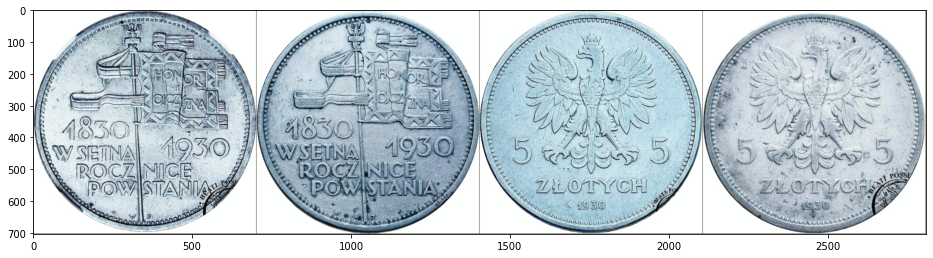

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,5))
imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0160 Acc: 0.5620
val Loss: 0.6955 Acc: 0.6856

Epoch 1/9
----------
train Loss: 0.9068 Acc: 0.6509
val Loss: 0.6436 Acc: 0.7195

Epoch 2/9
----------
train Loss: 0.7321 Acc: 0.6934
val Loss: 0.7429 Acc: 0.7252

Epoch 3/9
----------
train Loss: 0.6623 Acc: 0.7360
val Loss: 0.7809 Acc: 0.7507

Epoch 4/9
----------
train Loss: 0.5276 Acc: 0.7895
val Loss: 1.0404 Acc: 0.7195

Epoch 5/9
----------
train Loss: 0.4995 Acc: 0.8054
val Loss: 0.8173 Acc: 0.6544

Epoch 6/9
----------
train Loss: 0.5281 Acc: 0.8041
val Loss: 1.2722 Acc: 0.7394

Epoch 7/9
----------
train Loss: 0.2892 Acc: 0.8954
val Loss: 0.6850 Acc: 0.7252

Epoch 8/9
----------
train Loss: 0.2424 Acc: 0.9173
val Loss: 0.6638 Acc: 0.7564

Epoch 9/9
----------
train Loss: 0.1787 Acc: 0.9489
val Loss: 0.7019 Acc: 0.7337

Training complete in 6m 51s
Best val Acc: 0.756374
